In [67]:
import keras
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt
# 位置编码
def positional_embedding(maxlen, model_size):
    PE = np.zeros((maxlen, model_size))
    for i in range(maxlen):
        for j in range(model_size):
            if j % 2 == 0:
                PE[i, j] = np.sin(i / 10000 ** (j / model_size))
            else:
                PE[i, j] = np.cos(i / 10000 ** ((j-1) / model_size))
    PE = tf.constant(PE, dtype=tf.float32)
    return PE

def conv_model(input_seq):
    inputs = input_seq
    conv1 = layers.Conv1D(filters=32,kernel_size=12,strides=1,name="ConVLayers1")(inputs)
    conv2 = layers.Conv1D(filters=32,kernel_size=8,strides=1,name="ConVLayers2")(inputs)
    conv3 = layers.Conv1D(filters=64,kernel_size=4,strides=1,name="ConVLayers3")(inputs)
    word1 = layers.MaxPooling1D(pool_size=5,name="MP1D1")(conv1)
    word2 = layers.MaxPooling1D(pool_size=9,name="MP1D2")(conv2)
    word3 = layers.MaxPooling1D(pool_size=13,name="MP1D3")(conv3)
    word = layers.Concatenate()([word1,word2,word3])
    return word

In [68]:
def transformer(query,key,value,i):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads = 8,
        key_dim = 16,
        name = "encoder_{}_MHA".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1)(
        attention_output
    )
    q_att_ouput = layers.Add(name="encoder_{}_ATTadd".format(i))([query,attention_output])
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_ATTNorm".format(i)
    )(q_att_ouput)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(128, activation="relu"),
            layers.Dense(128),
        ],
        name="encoder_{}_FFN".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1)(
        ffn_output
    )
    a_ffn_output = layers.Add(name="encoder_{}_FFNadd".format(i))([ffn_output,attention_output])
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_FFNNorm".format(i)
    )(a_ffn_output)
    return sequence_output

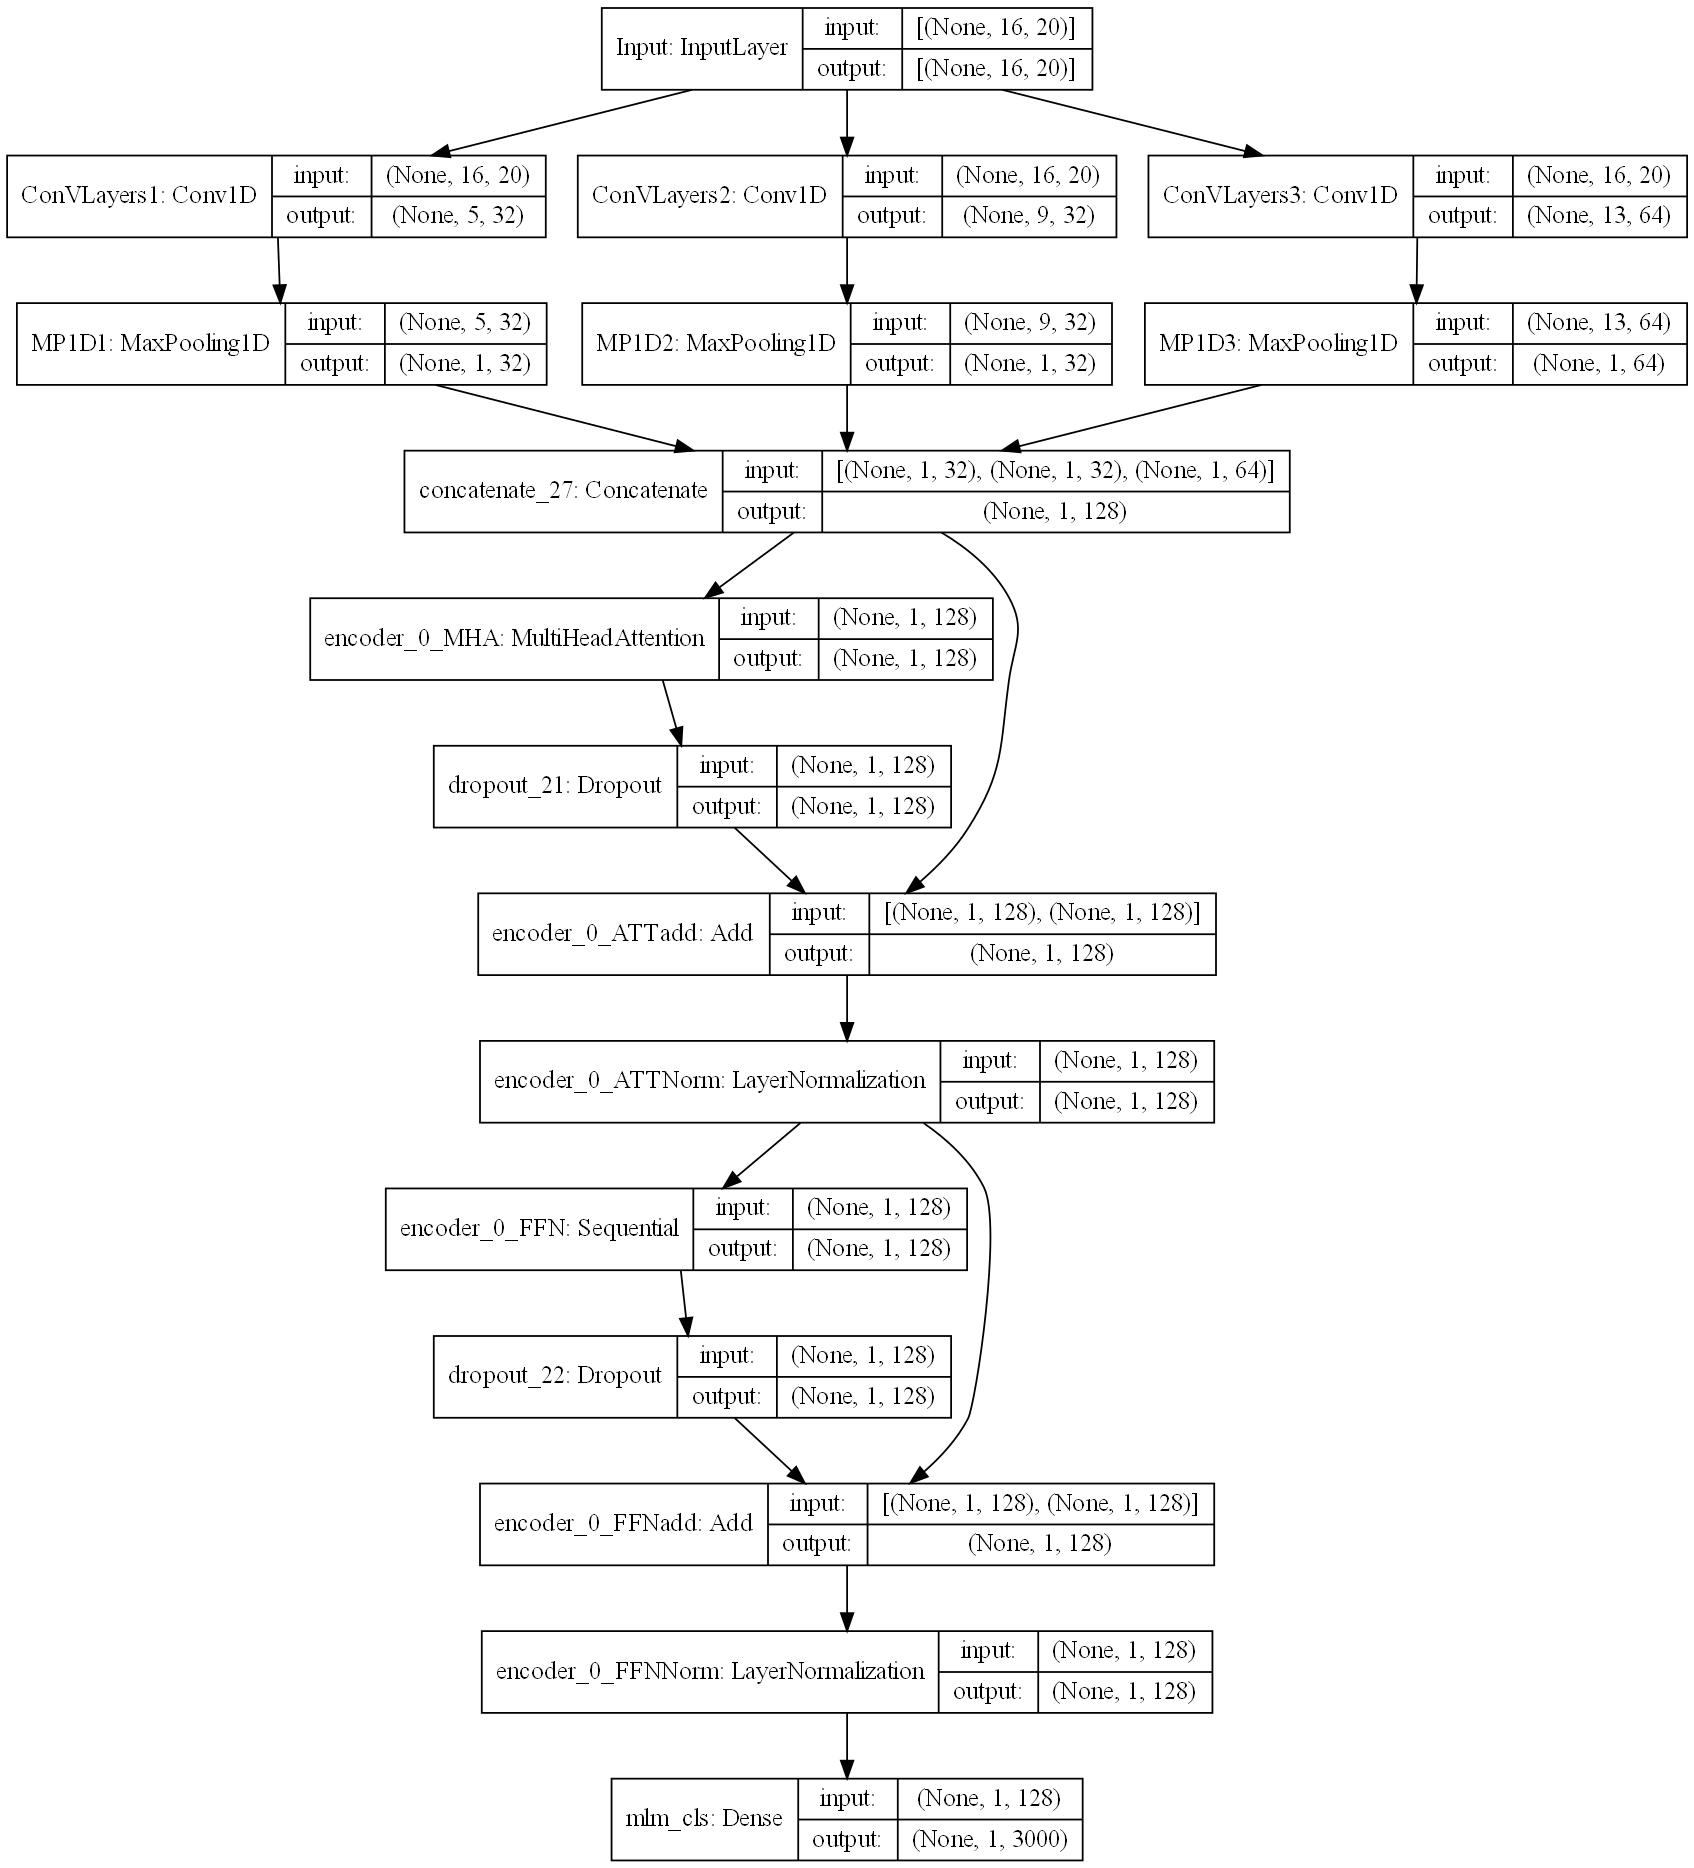

In [70]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE
)
loss_tracker = tf.keras.metrics.Mean(name="loss")

class MaskedLanguageModel(tf.keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker]

def create_masked_language_bert_model():
    inputs = layers.Input((16,20),name='Input')
    encoder_output = conv_model(inputs)
    for i in range(1):
        encoder_output = transformer(encoder_output, encoder_output, encoder_output, i)

    mlm_output = layers.Dense(3000, name="mlm_cls", activation="softmax")(
        encoder_output
    )
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model

transformer_model = create_masked_language_bert_model()
plot_model(transformer_model,to_file="model.png", show_shapes=True, show_layer_names=True, dpi=128,rankdir='TB')